In [0]:
# %******************************************************************************************************************%
# % The AIC19 benchmark is captured by 40 cameras in real-world traffic surveillance environment.                    %
# % A total of 666 vehicles are annotated. 333 vehicles are used for training. The remaining 333 vehicles are for    %
# % testing.                                                                                                         %
# % There are 56277 images in total. 18290 images are in the test set, and 36935 images are in the training set.     %
# %******************************************************************************************************************%

# Content in the directory:
# 1. "image_query/". This dir contains 1052 images as queries. 
# 2. "image_test/". This dir contains 18290 images for testing. 
# 3. "image_train/". This dir contains 36935 images for training. 
# 4. "name_query.txt". It lists all query file names.
# 5. "name_test.txt". It lists all test file names.
# 6. "name_train.txt". It lists all train file names.
# 7. "test_track.txt" & "test_track_id.txt". They record all testing tracks. Each track contains multiple images of the same vehicle captured by one camera.
# 8. "train_track.txt" & "train_track_id.txt". They record all training tracks. Each track contains multiple images of the same vehicle captured by one camera.
# 9. "train_label.xml". It lists the labels of vehicle ID and camera ID for training.
# 10. "train_label.csv". It lists the labels of vehicle ID in CSV format for training. 
# 11. "tool/visualize.py" & "tool/dist_example/". It is a Python tool for visualizing the results of vehicle re-identificaition, with an example of input data provided. 
# 12. "DataLicenseAgreement_AICityChallenge.pdf". The license agreement for the usage of this dataset. 

# If you have any question, please contact aicitychallenge2019@gmail.com.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#### !cp aic19-track2-reid.zip ../gdrive/My\ Drive/aic19-track2-reid.zip
!cp drive/My\ Drive/aic19-track2-reid.zip aic19-track2-reid.zip 
!unzip -qq aic19-track2-reid.zip

In [0]:
from pathlib import Path
import xml.etree.ElementTree as ET

dataset_path = Path('.')

with open(dataset_path/'train_label.xml','r') as f:
    ef = ET.fromstring(f.read())
    items = ef.getchildren()
    all_items = list(items[0].iter('Item'))
    all_items = [item.attrib for item in all_items]

In [0]:
len(all_items)

36935

In [0]:
all_items[0]

{'cameraID': 'c026', 'imageName': '021284.jpg', 'vehicleID': '0347'}

In [0]:
def get_train_tasks():
    with open(dataset_path/'train_track.txt', "r") as fo:
        lines = fo.readlines()
    lines = [line.split(' ')[:-1] for line in lines]
    return lines

def get_images(filename):
    with open(dataset_path/filename, "r") as fo:
        lines = fo.readlines()
    lines = [line[:-1] for line in lines]
    return lines

def get_associated_track_for_queries(queries, tracks):

    indices = [i for i in range(len(tracks))]
    query_to_track = {}
    no_tracks_found = []
    for query in queries:
        for track_idx in indices:
            if query in tracks[track_idx]:
                query_to_track[query] = tracks[track_idx]
                break

    return query_to_track

In [0]:
train_tracks_total = get_train_tasks()

# Filter those tracks which have less than 2 images
train_tracks_total = [track for track in train_tracks_total if len(track) >=2]
query_images = get_images("name_query.txt")
train_images = get_images("name_train.txt")

# query_to_track = get_associated_track_for_queries(query_images, train_tracks)

In [0]:
import math
import matplotlib.pyplot as plt

def show_images_in_track(track):
    img_folder_path = Path('image_train')
    num_images = len(track)
    num_cols = 5
    num_rows = math.ceil(1.0*num_images/num_cols)
    if num_rows == 1:
        num_cols = num_images
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10))

    row = 0
    col = 0
    for i, img_name in enumerate(track):
        img = plt.imread(img_folder_path/img_name)
        if num_rows == 1:
            current_axis = axs[col]
        else:
            current_axis = axs[row, col]
        current_axis.axis("off")
        current_axis.set_title(img_name)
        current_axis.imshow(img)

        col += 1

        if col == num_cols:
            col = 0
            row += 1
    
    if num_rows*num_cols > num_images:
        remaining_axes = num_rows*num_cols - num_images 
        for _ in range(remaining_axes):
            current_axis = axs[row, col]
            current_axis.axis("off")
            col += 1
            if col == num_cols:
                col = 0
                row += 1
    
    plt.show()

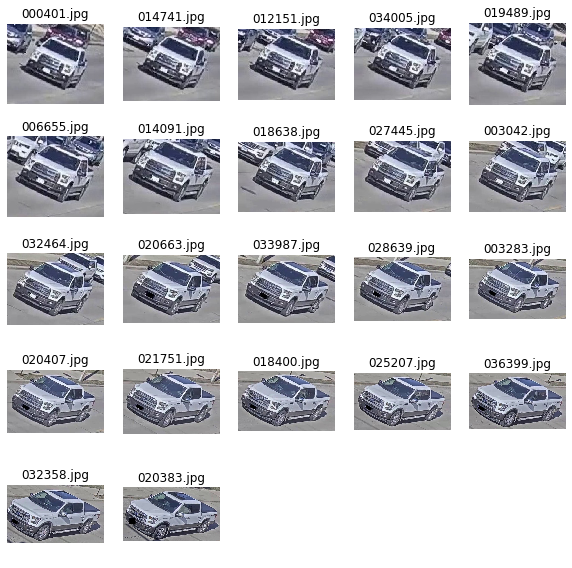

In [0]:
show_images_in_track(train_tracks_total[24])

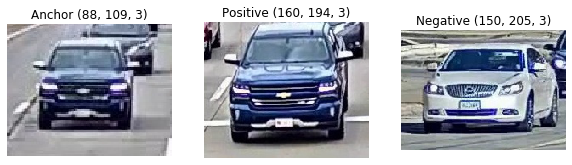

In [0]:
import numpy as np

def create_triplet_task(positive_track, negative_track):

    # positive_track, negative_track = np.random.choice(train_tracks, size=2, replace=False)
    anchor_image, positive_image = np.random.choice(positive_track, size=2, replace=False)
    negative_image = np.random.choice(negative_track)

    return anchor_image, positive_image, negative_image

def visualize_triplet_task(anchor_image, positive_track, negative_image):
    img_folder_path = Path('image_train')
    fig, axs = plt.subplots(1, 3, figsize=(10,10), gridspec_kw={'hspace': 0.2})
    images = [anchor_image, positive_track, negative_image]
    title = ["Anchor", "Positive", "Negative"]
    row = 0
    col = 0
    for i, img_name in enumerate(images):
        img = plt.imread(img_folder_path/img_name)
        axs[i].axis("off")
        axs[i].set_title(title[i] + " " + str(img.shape))
        axs[i].imshow(img)
    plt.show()

visualize_triplet_task(*create_triplet_task(*np.random.choice(train_tracks_total, size=2, replace=False)))

In [0]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image

class TripletDataset(Dataset):

    def __init__(self, tracks, image_path, image_size):
        self.tracks = tracks
        self.image_path = image_path
        self.image_size = image_size
    
    def __len__(self):
        return len(self.tracks)
    
    def applyTransforms(self, image):
        image_resized = TF.resize(image, self.image_size)
        image_tensor = TF.to_tensor(image_resized)
        return image_tensor
    
    def __getitem__(self, idx):
        positive_track = self.tracks[idx]
        negative_track_index = (idx + np.random.randint(1, len(self.tracks))) % len(self.tracks)
        assert idx != negative_track_index
        negative_track = self.tracks[negative_track_index]
        anchor_image, positive_image, negative_image = create_triplet_task(positive_track, negative_track)
        images = [anchor_image, positive_image, negative_image]
        images = [Image.open(self.image_path/image) for image in images]
        images = [self.applyTransforms(image) for image in images]
        anchor_image, positive_image, negative_image = images
        return anchor_image, positive_image, negative_image

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBatchNormBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBatchNormBlock, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels, out_channels, 3)
        self.max_pooling = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv_layer(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        out = self.max_pooling(out)
        return out

In [0]:
class EmbeddingNet(nn.Module):

    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv_block1 = ConvBatchNormBlock(3, 16)
        self.conv_block2 = ConvBatchNormBlock(16, 32)
        self.conv_block3 = ConvBatchNormBlock(32, 64)
        self.conv_block4 = ConvBatchNormBlock(64, 128)
        self.conv_block5 = ConvBatchNormBlock(128, 256)
        self.flatten_adaptive_pooling = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = self.conv_block4(out)
        out = self.conv_block5(out)
        out = self.flatten_adaptive_pooling(out)
        out = out.view(batch_size, -1)
        return out

In [0]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.embeddingnet = EmbeddingNet()

    def getEmbedding(self, x):
        return self.embeddingnet(x)
        
    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

In [0]:
from sklearn.model_selection import train_test_split

train_tracks, val_tracks = train_test_split(train_tracks_total, test_size=0.33, random_state=42)
print("Training Size - {}".format(len(train_tracks)))
print("Validation Size - {}".format(len(val_tracks)))

Training Size - 1239
Validation Size - 611


In [0]:
NUM_EPOCHS = 10
from tqdm import tqdm_notebook, trange, tqdm
import torch.optim as optim

triplet_model = TripletNet().cuda()
criterion = nn.MarginRankingLoss(margin = 0.5)
optimizer = optim.Adam(triplet_model.parameters(), lr=0.001)

losses = []

for epoch in trange(NUM_EPOCHS):
    triplet_dataset = TripletDataset(train_tracks, Path('image_train'), (256, 256))
    triplet_dataloader = DataLoader(triplet_dataset, batch_size=32, shuffle=True, num_workers=4)

    for triplet_batch in triplet_dataloader:
        anchors, positives, negatives = triplet_batch
        anchors, positives, negatives = anchors.cuda(), positives.cuda(), negatives.cuda()
        dist_a, dist_b, embedded_x, embedded_y, embedded_z = triplet_model(anchors, positives, negatives)
        target = torch.FloatTensor(dist_a.size()).fill_(1).cuda()
        loss_triplet = criterion(dist_a, dist_b, target)
        loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
        loss = loss_triplet + 0.001 * loss_embedd

        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 10/10 [03:24<00:00, 20.27s/it]


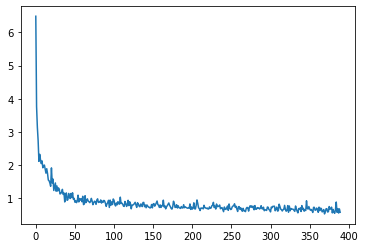

In [0]:
plt.plot(losses)

In [0]:
class ImageDataset(Dataset):

    def __init__(self, images, root_folder, image_size):
        self.images = images
        self.root_folder = root_folder
        self.image_size = image_size
    
    def __len__(self):
        return len(self.images)
    
    def applyTransforms(self, image):
        image_resized = TF.resize(image, self.image_size)
        image_tensor = TF.to_tensor(image_resized)
        return image_tensor
    
    def __getitem__(self, idx):
        image = Image.open(self.root_folder/self.images[idx])
        image = self.applyTransforms(image)
        return image

In [0]:
train_images = get_images("name_train.txt")

train_images_dataset = ImageDataset(train_images, Path("image_train"), (256, 256))
train_images_dataloader = DataLoader(train_images_dataset, num_workers=4, batch_size=64)

In [0]:
%%time
with torch.no_grad():
    triplet_model = triplet_model.eval()
    for image_batch in tqdm(train_images_dataloader):
        image_batch = image_batch.cuda()
        embeddings = triplet_model.getEmbedding(image_batch)

100%|██████████| 578/578 [02:26<00:00,  3.95it/s]

CPU times: user 9.05 s, sys: 8.39 s, total: 17.4 s
Wall time: 2min 26s
